In [1]:
using Pkg
Pkg.activate("C:/Users/ibzja/Documents/UPF_2022_2026/4t/2n_trimestre/Practiques_tutelades/CellBasedModels.jl")


  Activating project at `C:\Users\ibzja\Documents\UPF_2022_2026\4t\2n_trimestre\Practiques_tutelades\CellBasedModels.jl`


In [2]:
using CellBasedModels 
using GeometryBasics
using Distributions
using GLMakie

In [3]:
Makie.inline!(true)

true

In [ ]:
rods2DChemotaxis = ABM(2,
    agent = Dict(
        :vx => Float64,
        :vy => Float64,
        :theta => Float64,
        :ω => Float64,
        :d => Float64,
        :l => Float64,
        :m => Float64,
        :fx => Float64,
        :fy => Float64,
        :W => Float64,
        :pressure => Float64,
        :tTumble => Float64,
        :active => Bool,

        # Chemotaxis source
        :isSource => Bool,
        # :σ => Float64,
        :S => Float64,
        # :dS => Float64
    ),

    model = Dict(
        :kn => Float64,
        :γn => Float64,
        :γt => Float64,
        :μcc => Float64,
        :μcw => Float64,
        :β => Float64,
        :βω => Float64,
        :ωTumble => Float64,
        :τTumble => Float64,
        :fChem => Float64,
        :DMedium => Float64
    ),

    medium = Dict(
        :mm => Float64
    ),

    agentODE = quote
        fx = 0.0
        fy = 0.0
        W = 0.0
        pressure = 0.0

        @loopOverNeighbors j begin
            Fijx, Fijy, Wij = CBMModels.rodForces(
                x, y, d, l, theta, vx, vy, m,
                x[j], y[j], d[j], l[j], theta[j], vx[j], vy[j], m[j],
                kn, γn, γt, μcc, μcw
            )

            fx += Fijx
            fy += Fijy
            W += Wij
            pressure += sqrt(Fijx^2 + Fijy^2)
        end

        dt(x) = vx
        dt(y) = vy
        dt(vx) = -β * vx + fx / m + active * fChem * cos(theta)
        dt(vy) = -β * vy + fy / m + active * fChem * sin(theta)
        dt(theta) = ω
        dt(ω) = W / (m * (d + l)^2 / 12 + m * d^2) - βω * ω
    end,

    agentRule = quote
        # Chemotaxis source agent
        if isSource
            # S = S0 * (1 + sin(ω*t))
            mm += S
            return
        end

        # Run-and-tumble dynamics
        if tTumble < t && active
            vx = 0.0
            vy = 0.0
            active = false
            ω += ωTumble
            tTumble += 1.0
        elseif tTumble < t && !active
            ω = 0.0
            active = true
            tTumble += CBMDistributions.exponential((2 - mm) * τTumble)
        end
        # Very rudementary rule to to fix the bacteries to move inside the boundaries using onluy the center of the rod
        if x < simBox[1,1]
            x = simBox[1,1]
        elseif x > simBox[1,2]
            x = simBox[1,2]
        end
        if y < simBox[2,1]
            y = simBox[2,1]
        elseif y > simBox[2,2]
            y = simBox[2,2]
        end
    end,

    mediumODE = quote
        if @mediumInside()
            dt(mm) = DMedium *(@∂2(1, mm)+ @∂2(2, mm))
        end
    end,

    neighborsAlg = CBMNeighbors.CellLinked(cellEdge = 4)
)


PARAMETERS
	x (Float64 agent)
	y (Float64 agent)
	xₘ (Float64 medium)
	yₘ (Float64 medium)
	d (Float64 agent)
	active (Bool agent)
	isSource (Bool agent)
	fx (Float64 agent)
	vx (Float64 agent)
	l (Float64 agent)
	m (Float64 agent)
	fy (Float64 agent)
	pressure (Float64 agent)
	vy (Float64 agent)
	ω (Float64 agent)
	W (Float64 agent)
	S (Float64 agent)
	tTumble (Float64 agent)
	theta (Float64 agent)
	γn (Float64 model)
	μcw (Float64 model)
	ωTumble (Float64 model)
	β (Float64 model)
	DMedium (Float64 model)
	γt (Float64 model)
	μcc (Float64 model)
	kn (Float64 model)
	fChem (Float64 model)
	βω (Float64 model)
	τTumble (Float64 model)
	mm (Float64 medium)


UPDATE RULES
mediumODE
 if @mediumInside()
    dt__mm = DMedium * (@∂2(1, mm) + @∂2(2, mm))
end

agentRule
 begin
    if isSource
        mm__ += S
        return
    end
    if tTumble < t && active
        vx__ = 0.0
        vy__ = 0.0
        active__ = false
        ω__ += ωTumble
        tTumble__ += 1.0
    elseif tTumble < t &

In [12]:
com = Community(
    rods2DChemotaxis;
    N = 2,
    dt = 0.1,
    simBox = [-20.0 20.0; -20.0 20.0],
    NMedium = [200, 200]
)

m = 1 / 100
g = 1 / 10000
d = 1.0

com.kn = 2e6 * (m * g / d)
com.γn = 2.2e2 * sqrt(g / d)
com.γt = 2.2e2 * sqrt(g / d)
com.μcc = 0.1
com.μcw = 0.8
com.β = 0.8
com.βω = 0.8
com.fChem = 1.0
com.τTumble = 2.0
com.ωTumble = 1.0
# com.ωMedium = 0.01
com.DMedium = 0.1

com.m .= 1.0
com.d .= 1.0
com.l .= 3.0

com.x .= rand(Uniform(com.simBox[1, 1], com.simBox[1, 2]), com.N)
com.y .= rand(Uniform(com.simBox[2, 1], com.simBox[2, 2]), com.N)
com.theta .= rand(Uniform(0, 2π), com.N)

com.vx .= 0.0
com.vy .= 0.0
com.active .= true
com.tTumble .= 0.0

# Chemotaxis source agent
src = 1

com.isSource .= false
com.isSource[src] = true

com.x[src] = 0.0
com.y[src] = 0.0
com.vx[src] = 0.0
com.vy[src] = 0.0
com.active .= true #keep others active and moving
com.active[src] = false   # keep source inactive,  Source does not run/tumble- que passa si si que esta activa?

# com.σ .= 0.0
com.S .= 0.0
# com.dS .= 0.0

# com.σ[src] = 2.0
com.S[src] = 2.0
# com.dS[src] = 0.01


2.0

In [13]:
evolve!(com, steps = 4000, saveEach = 10)

In [8]:
function plotRods2D!(ax, x, y, d, l, angle; kargs...)

    Main.meshscatter!(ax,
                x.+l./2 .*cos.(angle),
                y.+l./2 .*sin.(angle),
                marker=Sphere(Point3f(0,0,0.),Float32(1)),
                markersize=[
                    Point3f(i/2,i/2,0)
                    for i in d
                ],
                kargs...
            )

    Main.meshscatter!(ax,
                x.-l./2 .*cos.(angle),
                y.-l./2 .*sin.(angle),
                marker=Sphere(Point3f(0,0,0),Float32(1)),
                markersize=[
                    Point3f(i/2,i/2,0)
                    for i in d
                ],
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=Cylinder(Point3f(-.5,0,0),Point3f(.5,0,0),Float32(1)),
                markersize=[Point3f(ll,dd/2,dd/2) for (ll,dd) in zip(l,d)],
                rotation=angle,
                kargs...
            )

    return

end

function plotRods2D!(ax, x, y, xs1, ys1, xs2, ys2, markerSphere, markerCylinder, angle; kargs...)

    m = meshscatter!(ax,
                xs1,
                ys1,
                marker=Sphere(Point3f(0,0,0.),Float32(1)),
                markersize=markerSphere;
                kargs...
            )

    Main.meshscatter!(ax,
                xs2,
                ys2,
                marker=Sphere(Point3f(0,0,0),Float32(1)),
                markersize=markerSphere;
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=Cylinder(Point3f(-.5,0,0),Point3f(.5,0,0),Float32(1)),
                markersize=markerCylinder,
                rotation=angle;
                kargs...
            )

    return m

end

plotRods2D! (generic function with 2 methods)

In [34]:
for (j,i) in enumerate(1:round(Int,length(com)/4):length(com))
    println(com[i][:x])
    println(com[i][:y])
end

[0.0, -14.639644093515313]
[0.0, -0.9980344559655161]
[0.0, -46.65458304158031]
[0.0, 119.13031927991776]
[0.0, -78.84430754802189]
[0.0, 239.9145137599972]
[0.0, -111.03403205445964]
[0.0, 360.69870824005307]


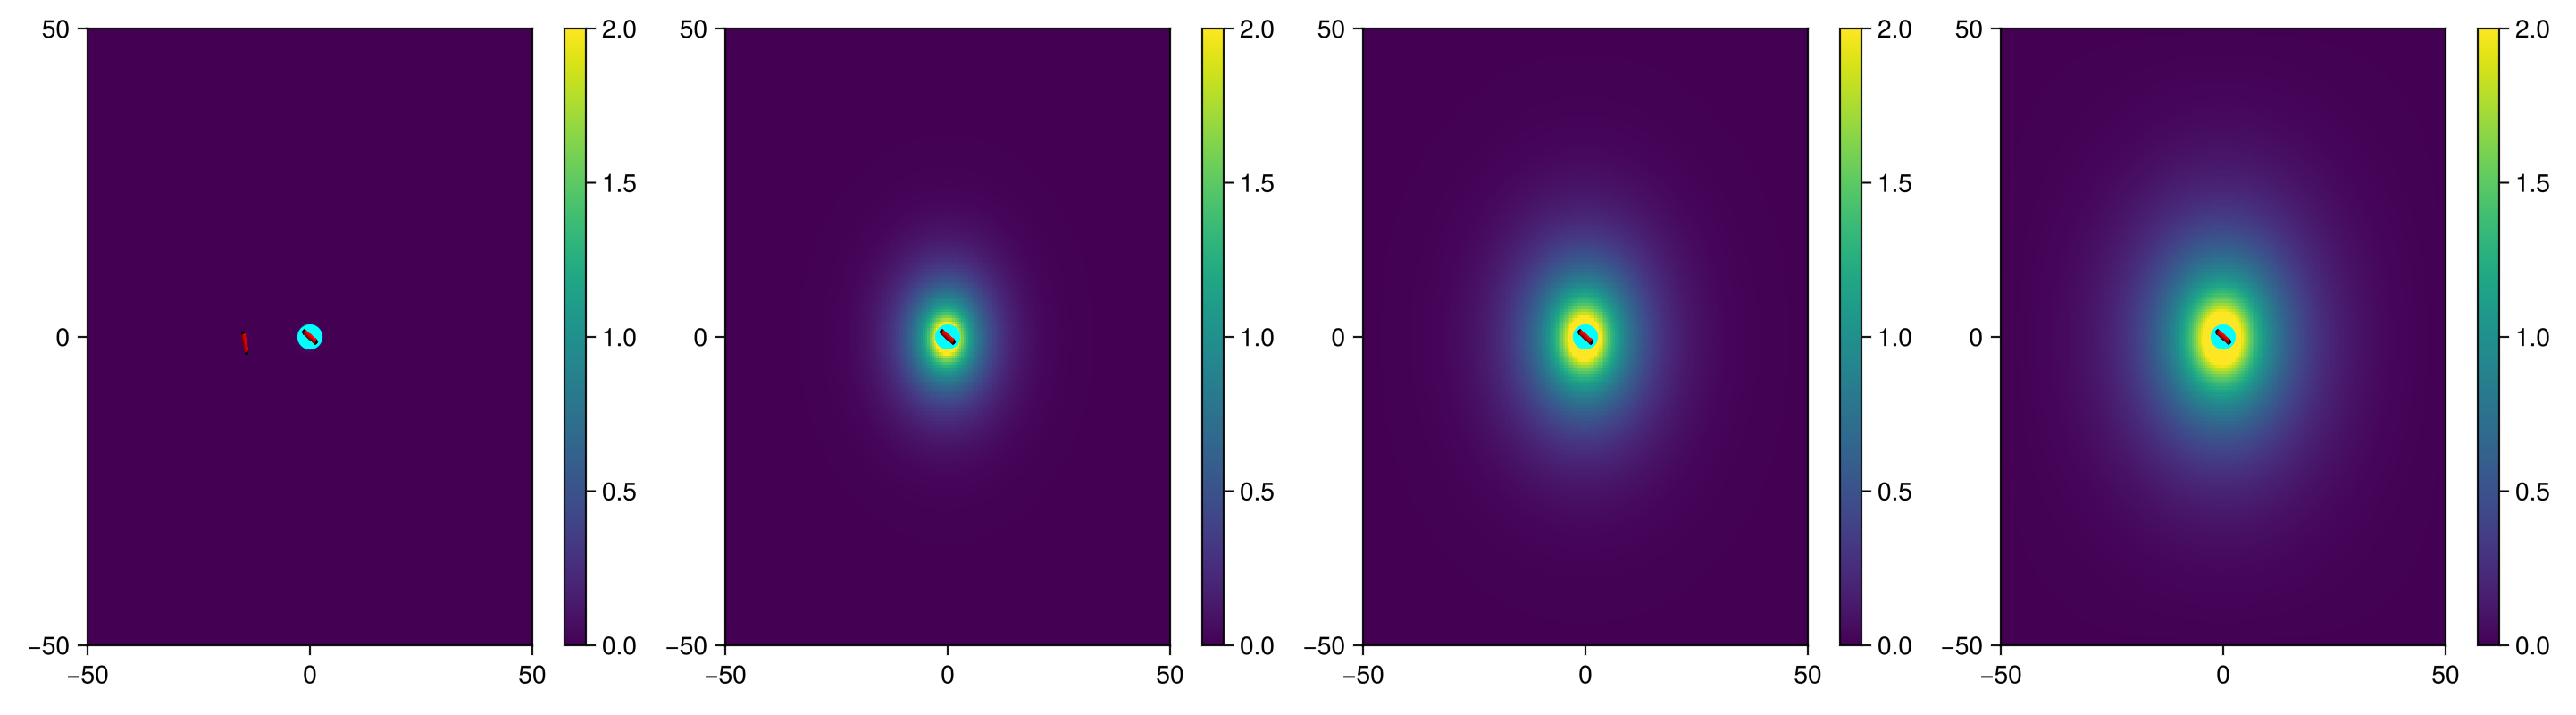

GLMakie.Screen(...)

In [ ]:
fig = Figure(size = (1800, 400))

for (j,i) in enumerate(1:round(Int,length(com)/4):length(com))
    begin
        d = getParameter(com,[:x,:y,:d,:l,:theta,:pressure,:mm, :isSource])

        ax = Axis(fig[1, 2*j-1])

        # nx, ny = size(d[:mm][i])
        # hm = heatmap!(
        #     ax,
        #     range(com.simBox[1,1], com.simBox[1,2], length=nx),
        #     range(com.simBox[2,1], com.simBox[2,2], length=ny),
        #     d[:mm][i]
        # )

        hm = heatmap!(ax,
                # range(com.simBox[1,1],com.simBox[1,2],length=size(com.mm)[1]),
                # range(com.simBox[2,1],com.simBox[2,2],length=size(com.mm)[1]),
                range(-50,50,length=size(com.mm)[1]),
                range(-50,50,length=size(com.mm)[1]),
                d[:mm][i],
                colorrange=(0,2.)
            )
        # mark chemotactic source
        src = findall(d[:isSource][i])
        scatter!(
            ax,
            d[:x][i][src],
            d[:y][i][src],
            color = :cyan,
            markersize = 20
        )

        # rods
        x = Observable(d[:x][i])
        y = Observable(d[:y][i])

        xs1 = Observable(d[:x][i] .+ d[:l][i]./2 .* cos.(d[:theta][i]))
        ys1 = Observable(d[:y][i] .+ d[:l][i]./2 .* sin.(d[:theta][i]))
        xs2 = Observable(d[:x][i] .- d[:l][i]./2 .* cos.(d[:theta][i]))
        ys2 = Observable(d[:y][i] .- d[:l][i]./2 .* sin.(d[:theta][i]))

        ms = Observable([Point3f(dd/2, dd/2, 0) for dd in d[:d][i]])
        mc = Observable([Point3f(ll, dd/2, dd/2) for (ll, dd) in zip(d[:l][i], d[:d][i])])

        theta = Observable(d[:theta][i])

        plotRods2D!(
            ax,
            x, y, xs1, ys1, xs2, ys2,
            ms, mc, theta,
            color = :red
        )

        # xlims!(ax, com.simBox[1,:]...)
        # ylims!(ax, com.simBox[2,:]...)
        xlims!(ax, (-50,50)...)
        ylims!(ax, (-50,50)...)

    end

    Colorbar(fig[1, 2j], hm)
end

display(fig)


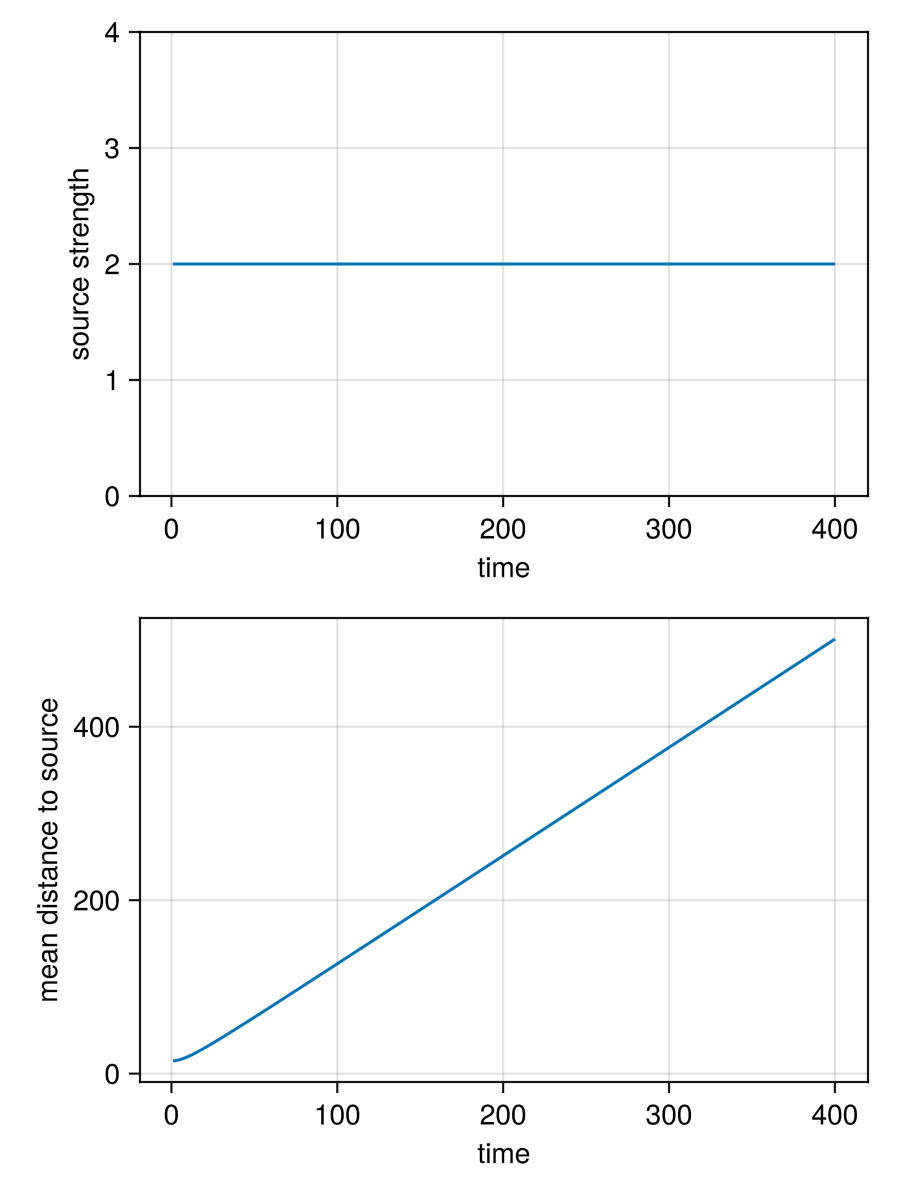

GLMakie.Screen(...)

In [15]:
using Statistics

d = getParameter(com, [:x, :y, :S, :isSource])

src_id = findfirst(d[:isSource][1])

t = [pt.t for pt in com.pastTimes]

# source strength
Ssrc = [d[:S][k][src_id] for k in eachindex(t)]

# mean distance to source
mean_dist = [
    mean(
        sqrt.(
            (d[:x][k] .- d[:x][k][src_id]).^2 .+
            (d[:y][k] .- d[:y][k][src_id]).^2
        )[.!d[:isSource][k]]
    )
    for k in eachindex(t)
]

fig = Figure(size=(450, 600))

ax1 = Axis(fig[1,1], xlabel="time", ylabel="source strength")
lines!(ax1, t, Ssrc)

ax2 = Axis(fig[2,1], xlabel="time", ylabel="mean distance to source")
lines!(ax2, t, mean_dist)

display(fig)
